# Introduction
On 25 and 26 Sep 2020 occurred an early snowfall in the Pyrenees. The snow cover area [was captured by Sentinel-2](https://labo.obs-mip.fr/multitemp/september-snow-captured-by-sentinel-2/) the day after on Sep 27. Here we use the Sentinel-2 data to characterize the spatial differences in the snowline elevation. Since the image was captured right after the snowfall, these differences should reflect those of the zero degree isotherm elevation during the snowfall.

Author: simon.gascoin@cesbio.cnes.fr (04 oct 2020)

In [57]:
from scipy import ndimage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gdal # could be skipped if not installed
import pyproj
from datetime import datetime as dt
%matplotlib inline

In [2]:
# path to the Theia snow product 2020-Sep-27 tile 30TYN (Central Pyrenees)
# Theia data can be obtained from https://theia.cnes.fr/atdistrib/rocket/#/search?collection=Snow
f = 'SENTINEL2A_20200927-105922-256_L2B-SNOW_T30TYN_C_V1-7/SENTINEL2A_20200927-105922-256_L2B-SNOW_T30TYN_C_V1-7_SNW_R2.tif'
# The DEM can be made from the freely available void-filled SRTM DEM (USGS/NASA) and resampled to S2 grid using gdal or QGIS
fdem = 'DEM_30TYN.tif'

In [3]:
# the same analysis can be done with the neighbouring tile 31TCH (Eastern Pyrenees)
#f = 'SENTINEL2A_20200927-105918-371_L2B-SNOW_T31TCH_C_V1-7/SENTINEL2A_20200927-105918-371_L2B-SNOW_T31TCH_C_V1-7_SNW_R2.tif'
#fdem = 'DEM_31TCH.tif'

In [4]:
# load product as numpy array
I = np.array(Image.open(f))

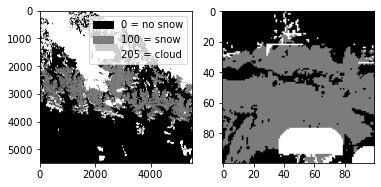

In [5]:
# plot the snow product
fig, (ax1, ax2) = plt.subplots(1, 2)
im = ax1.imshow(I,'gray')
labels = ['0 = no snow','100 = snow','205 = cloud']
values = [0,100,205]

# add legend (https://stackoverflow.com/a/40666123)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)) ]
im.axes.legend(handles=patches)

# zoom over a subset
ax2.imshow(I[1600:1700, 800:900],'gray');

In [6]:
# Snow and cloud binary images
S = (I==100).astype(int)
C = (I==205).astype(int)

In [7]:
# Pixels marking the snow mask edges (inner boundary)
edgesSnowIn = S - ndimage.binary_erosion(S)
# Pixels marking the cloud mask edges (outer boundary)
edgesCloudOut = abs(C - ndimage.binary_dilation(C))
# The snowline pixels are the snow mask boundaries only if there is no adjacent cloud
snowline = (edgesSnowIn==1) & (edgesCloudOut==0)

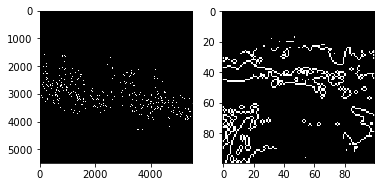

In [8]:
# plot snowline pixels
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(snowline,'gray',interpolation='none')
ax2.imshow(snowline[1600:1700, 800:900],'gray',interpolation='none');

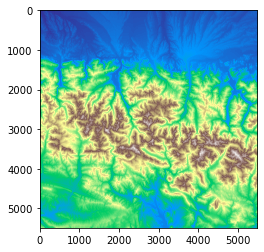

In [9]:
# load digital elevation model (already resampled to Sentinel-2 grid)
Z = np.array(Image.open(fdem))
plt.imshow(Z,'terrain');

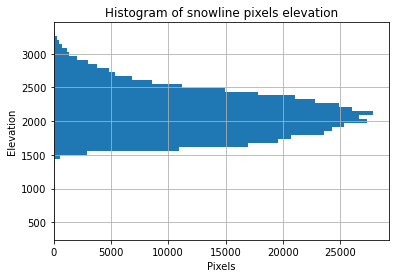

In [10]:
# extract elevation of snowline pixels
Zsnowline = Z[snowline]
# draw histogram 
plt.hist(Zsnowline, 50, orientation='horizontal')
plt.ylabel('Elevation')
plt.xlabel('Pixels')
plt.title('Histogram of snowline pixels elevation')
plt.grid(True)

In [11]:
# To relate the snowline to geographic position we need to read the metadata from the GeoTiff image
gtif = gdal.Open(f)
geoMatrix = gtif.GetGeoTransform()
# upper left corner x coordinate
ulx = geoMatrix[0]
# upper left corner y coordinate
uly = geoMatrix[3]
# pixel spacing in x 
xd = geoMatrix[1]
# pixel spacing in y
yd = geoMatrix[5]
# number of pixels in x
nx = gtif.RasterXSize
# number of pixels in y
ny = gtif.RasterYSize
# upper right corner x coordinate
urx = ulx + xd*nx
# lower left corner y coordinate
lly = uly + yd*ny

In [12]:
# if gdal module is not installed, the same information can be obtained from gdalinfo in the terminal
# it is also useful to check the corner coordinates calculations
import os; print(os.popen('gdalinfo '+f+' |tail').read())

  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  699960.000, 4800000.000) 
Lower Left  (  699960.000, 4690200.000) 
Upper Right (  809760.000, 4800000.000) 
Lower Right (  809760.000, 4690200.000) 
Center      (  754860.000, 4745100.000) 
Band 1 Block=5490x1 Type=Byte, ColorInterp=Gray



In [13]:
# create northing and easting arrays of pixel centers
x = np.linspace(ulx+xd/2, urx-xd/2, nx)
y = np.linspace(uly+yd/2, lly-yd/2, ny)
X, Y = np.meshgrid(x, y, indexing='xy')

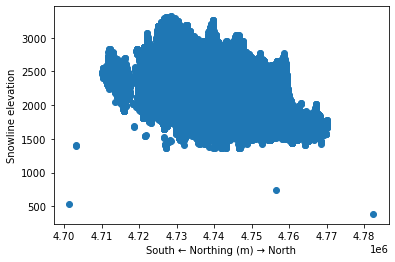

In [14]:
# extract northing of snowline pixels
Ysnowline = Y[snowline]
# plot snowline elevation vs. northing
plt.scatter(Ysnowline, Zsnowline)
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline elevation');

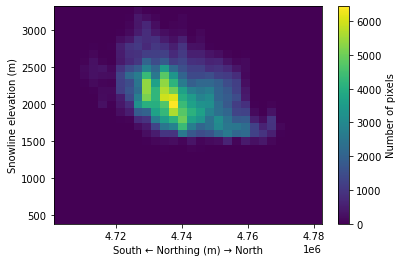

In [15]:
# because there are too many points it is better to redraw the previous figure as a 2D histogram
plt.hist2d(Ysnowline, Zsnowline, bins=(30, 30))
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline elevation (m)')
plt.colorbar().set_label('Number of pixels')

In [16]:
# We want to evaluate the evolution of the snowline elevation along the north-south direction 
# We use the 10% percentile of the snowline elevation as the snowline low limit
# first construct a snowline elevation array with NaN outside the snowline pixels
ZOnsnowline = np.where(snowline,Z,np.nan)
# use nanpercentile (percentile function not implemented for masked arrays)
p10y = np.nanpercentile(ZOnsnowline,10,axis=1)

/Users/gascoins/Apps/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


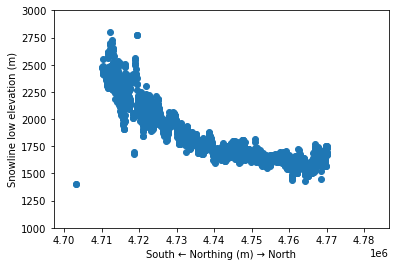

In [17]:
# plot snowline low elevation vs. northing
plt.scatter(y,p10y)
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline low elevation (m)')
plt.ylim(1000,3000);

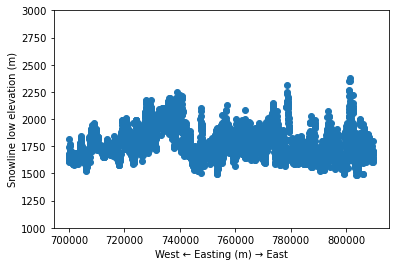

In [18]:
# same analysis along the east-west direction
p10x = np.nanpercentile(ZOnsnowline,10,axis=0)
plt.scatter(x,p10x)
plt.xlabel('West ← Easting (m) → East')
plt.ylabel('Snowline low elevation (m)')
plt.ylim(1000,3000);

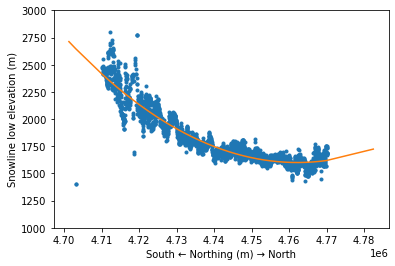

In [19]:
# Fit a polynomial function to model the variation of the snowline low elevation with northing
ix = np.logical_not(np.isnan(p10y))
fit = np.polyfit(y[ix], p10y[ix], 2)
p = np.poly1d(fit)
plt.plot(y[ix], p10y[ix], '.', y[ix], p(y[ix]), '-')
plt.xlabel('South ← Northing (m) → North')
plt.ylabel('Snowline low elevation (m)')
plt.ylim(1000,3000);

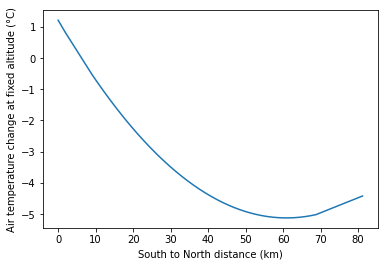

In [20]:
# use this function to model the variation of the air temperature at fixed level with northing
# assume a fixed temperature lapse rate
gradT = 0.0057 # air temperature gradient with altitude in °C/m
# From the above plot we had 0°C near 2500 m in the southern Pyrenees (0 km north)
plt.plot((y[ix]-y[ix].min())/1000, gradT*(p(y[ix])-2500), '-')
plt.xlabel('South to North distance (km)')
plt.ylabel('Air temperature change at fixed altitude (°C)');

# Conclusion
If the air temperature was 0°C at 2500 m in the southern Pyrenees, the air temperature was probably -5°C at the same altitude in the northern Pyrenees!

## Comparaison avec des données météo 
Source : https://www.meteoblue.com/fr/meteo/historyclimate/weatherarchive/

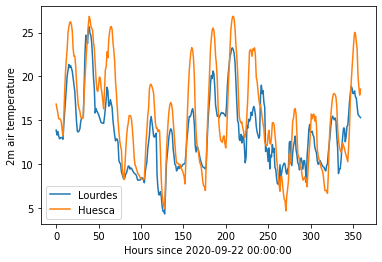

In [135]:
# plot 15 days of air temperature at Lourdes and Huesca (cities with similar elevation)
def loadMeteoBlue(f):
    """
    read data from meteoblue file
    :param f: filename
    :return: array
    """
    d = np.genfromtxt(f,skip_header=9,delimiter=',',names=True,
                 dtype = ['U50', 'f8', 'f8', 'f8', 'f8'])
    d['timestamp'] = [dt.strptime(x, '%Y%m%dT%H%M') for x in d['timestamp']]
    return d
    
metLourdes = loadMeteoBlue('meteo/meteoblueHistory/dataexport_20201006T115823_Lourdes.csv')
metFiscal = loadMeteoBlue('meteo/meteoblueHistory/dataexport_20201006T115716_Huesca.csv')
#plt.plot(metLourdes['timestamp'],metLourdes['Lourdes_Temperature_2_m_elevation_corrected']);
#plt.plot(metFiscal['timestamp'],metFiscal['Fiscal_Temperature_2_m_elevation_corrected']);
plt.plot(metLourdes['Lourdes_Temperature_2_m_elevation_corrected'],label='Lourdes');
plt.plot(metFiscal['Huesca_Temperature_2_m_elevation_corrected'],label='Huesca');
plt.xlabel('Hours since 2020-09-22 00:00:00')
plt.ylabel('2m air temperature')
plt.legend();

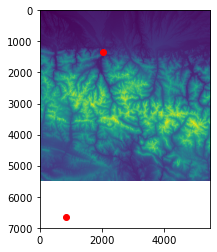

In [134]:
# Locate stations on the image (Lourdes and Bielsa)

def map2Pix(x, y, transform = None):
    """
    converts map coordinates to image pixel [col, row]
    :param x:
    :param y:
    :param transform:
    :return: col, row
    """
    if transform:
        # compute pixel offset
        col = int((x - transform[0]) / transform[1])
        row = int((y - transform[3]) / transform[5])
        return col, row

s = gtif.GetSpatialRef()
p = pyproj.Proj(s.ExportToProj4())
xo,yo = p((-0.04553,-0.37726),(43.07450,42.12207),inverse=False)
io,jo = map2Pix(xo[0],yo[0],transform=geoMatrix)
plt.imshow(Z);
plt.plot(*map2Pix(xo[0],yo[0],transform=geoMatrix),color='r',marker='o');
plt.plot(*map2Pix(xo[1],yo[1],transform=geoMatrix),color='r',marker='o');